# Fase 3: Entrenamieto y Versionado de Modelos

In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from datetime import datetime
import hashlib
import joblib
from datetime import datetime
import seaborn as sns

In [2]:
# carga de datos
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (840, 30)
X_test:  (291, 30)
y_train: (840,)
y_test:  (291,)


Cargamos los conjuntos de datos procesados (X_train, X_test, y_train, y_test) desde los archivos CSV que guardamos en el notebook anterior.

Al cargar y_train e y_test, usamos .ravel(). Esto los convierte en el vector 1D ((n_samples,)) que Scikit-learn espera, evitando problemas de formato al entrenar.

Finalmente, imprimimos las formas (shapes) de los datos. Es una verificación de sanidad para confirmar que todo se cargó correctamente antes de empezar a entrenar.

### 3.1. Modelos

In [3]:
# Definición de modelos
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=10),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

print(f"Modelos definidos: {list(models.keys())}")

Modelos definidos: ['Ridge', 'Lasso', 'RandomForest', 'LightGBM', 'XGBoost']


Creamos un diccionario (models) para almacenar las instancias de todos los algoritmos que vamos a evaluar. Seleccionamos una amplia gama de modelos para comparar. Incluimos modelos lineales (Ridge, Lasso) para establecer una base de rendimiento (baseline) robusta, y ensambles de árboles potentes (RandomForest, LightGBM, XGBoost) para capturar relaciones más complejas.

Usar un diccionario nos permite iterar y entrenar todos los modelos de forma automática en el siguiente paso.

In [4]:
# tracking de experimentos

os.makedirs('../results', exist_ok=True)
log_path = '../results/experiment_logs.csv'

def log_experiment(model_name, params, mae, rmse, r2):
    log_entry = {
        'model': model_name,
        'params': str(params),
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'timestamp': datetime.now().isoformat()
    }
    
    # Append to CSV
    log_df = pd.DataFrame([log_entry])
    if os.path.exists(log_path):
        log_df.to_csv(log_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_path, index=False)
    
    print(f"  - MAE: {mae:,.1f} | RMSE: {rmse:,.1f} | R²: {r2:.3f}")

print(f"Logs en: {log_path}")

Logs en: ../results/experiment_logs.csv


Definimos una función (log_experiment) para registrar los resultados de cada modelo (métricas, parámetros y timestamp) en un archivo CSV (experiment_logs.csv). Esta función es crucial para la MLOps.

La usamos para centralizar el logging y, al escribir en modo append (agregar), construimos un historial persistente de todas las corridas. Esto nos permite comparar objetivamente el rendimiento de los diferentes modelos y sus hiperparámetros.

In [5]:
# Entrenamiento y evaluación de modelos

results = []

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    # Log
    log_experiment(name, model.get_params(), mae, rmse, r2)
    
    results.append({'model': name, 'mae': mae, 'rmse': rmse, 'r2': r2, 'model_obj': model})

# Convertir a DF
results_df = pd.DataFrame(results).sort_values('mae')
print("\nRESULTADOS:")
print(results_df[['model', 'mae', 'rmse', 'r2']].round(2))


Entrenando Ridge...
  - MAE: 2,760.8 | RMSE: 3,954.1 | R²: 0.495

Entrenando Lasso...
  - MAE: 2,631.1 | RMSE: 3,459.2 | R²: 0.613

Entrenando RandomForest...


c:\Users\micae\anaconda3\envs\cervecera_env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.32223e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\micae\anaconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e+09, tolerance: 5.075e+06
  model = cd_fast.enet_coordinate_descent(


  - MAE: 2,692.8 | RMSE: 3,558.9 | R²: 0.591

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7465
[LightGBM] [Info] Number of data points in the train set: 840, number of used features: 30
[LightGBM] [Info] Start training from score 23627.410714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  - MAE: 2,863.5 | RMSE: 3,691.7 | R²: 0.559

Entrenando XGBoost...
  - MAE: 2,908.8 | RMSE: 3,764.8 | R²: 0.542

RESULTADOS:
          model      mae     rmse    r2
1         Lasso  2631.13  3459.15  0.61
2  RandomForest  2692.83  3558.85  0.59
0         Ridge  2760.81  3954.09  0.49
3      LightGBM  2863.54  3691.73  0.56
4       XGBoost  2908.84  3764.

Iteramos sobre el diccionario de modelos, entrenando cada uno con X_train y prediciendo con X_test.

Calculamos las métricas clave (MAE, RMSE, R²) y llamamos a log_experiment para guardar los resultados en nuestro CSV de tracking. Automatizamos el entrenamiento y el registro de todos los experimentos para una comparación objetiva.

Finalmente, creamos un DataFrame con los resultados y lo ordenamos por MAE para imprimir el ranking final. Usamos el MAE para identificar qué modelo tuvo, en promedio, el menor error de predicción (en kW).

In [6]:
# Reentrenamiento final con el mejor modelo
from sklearn.linear_model import Lasso

# Mejor modelo: Lasso
final_model = Lasso(alpha=1.0)

# Unir train + test
X_full = pd.concat([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

final_model.fit(X_full, y_full)
print("Modelo final reentrenado con todos los datos")

Modelo final reentrenado con todos los datos


c:\Users\micae\anaconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.262e+09, tolerance: 6.047e+06
  model = cd_fast.enet_coordinate_descent(


Identificamos el modelo ganador de nuestra evaluación (Lasso). Luego, combinamos los conjuntos de train y test (X_full, y_full). El split (división) de datos ya cumplió su propósito: evaluar y seleccionar el mejor modelo.

Finalmente, reentrenamos el modelo Lasso una última vez, pero ahora sobre el 100% de los datos. Al hacer esto, nos aseguramos de que el modelo final que se guardará para producción haya aprendido de la máxima cantidad de información disponible, lo que lo hace más robusto.

In [7]:
# Guardar el modelo final

os.makedirs('../models', exist_ok=True)

version = "v1.0.0"
model_path = f'../models/modelo_{version}.pkl'
joblib.dump(final_model, model_path)

print(f"Modelo final guardado: {model_path}")

Modelo final guardado: ../models/modelo_v1.0.0.pkl


Definimos un string de versión (ej. "v1.0.0"). Luego, guardamos (serializamos) el final_model (ya reentrenado con todos los datos) en el directorio ../models usando joblib.dump. Usamos joblib por ser el método preferido y más eficiente para guardar modelos de scikit-learn. Incluir la versión en el nombre del archivo (ej. modelo_v1.0.0.pkl) es una práctica clave de MLOps que nos permite versionar los artefactos y saber exactamente qué modelo se está desplegando.

In [8]:
# Crear registro del modelo
registry = {
    "version": version,
    "model": "Lasso",
    "path": model_path,
    "mae_val": 2631.13,
    "rmse_val": 3459.15,
    "r2_val": 0.61,
    "alpha": 1.0,
    "train_date": datetime.now().isoformat(),
}

registry_path = '../models/model_registry.json'
with open(registry_path, 'w') as f:
    json.dump(registry, f, indent=2)

print(f"Registry creado: {registry_path}")

Registry creado: ../models/model_registry.json


Creamos un diccionario (registry) que contiene toda la metadata clave del modelo que acabamos de guardar: la versión, el nombre (Lasso), su path, las métricas de validación (MAE, RMSE, R2), sus hiperparámetros (alpha=1.0) y la fecha de entrenamiento. Este es el manifiesto del modelo.

Guardamos este diccionario en model_registry.json. Este archivo centraliza la información. Permite que otros procesos (como un script de despliegue o una API) consulten y carguen la versión correcta del modelo y conozcan su rendimiento esperado sin tener que abrir el archivo .pkl. Es una práctica fundamental de MLOps para la gestión de artefactos.

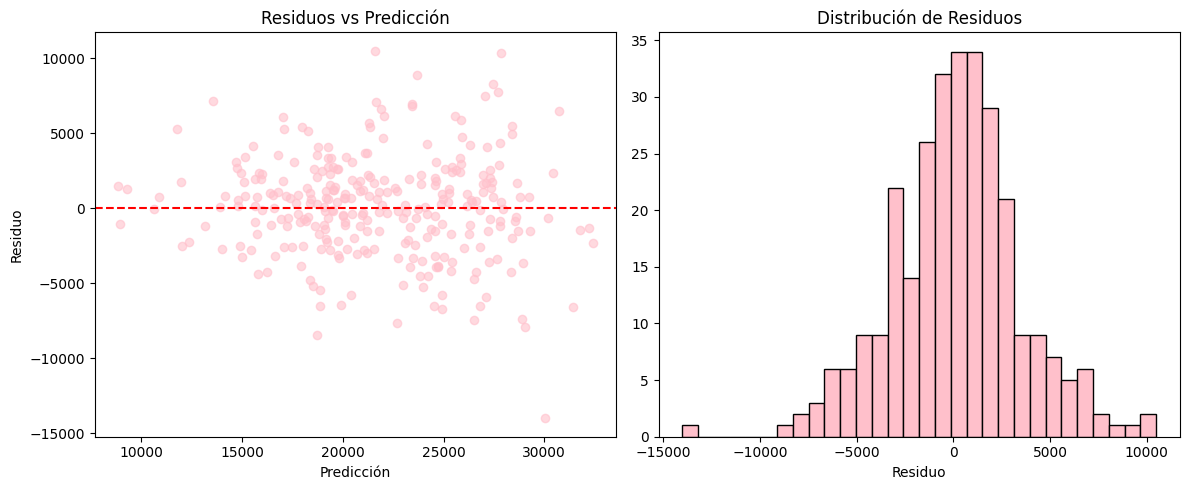

Top 10 coeficientes (Lasso):
rolling_7                                 4435.857361
Consolidado EE_Servicios (Kw)             2691.994370
rolling_30                                1839.520165
Totalizadores Energia_KW Linea 3          1502.229109
inter_agua_cond_x_frio                    1006.104143
Consolidado KPI_Aire Planta / Hl           338.658378
Consolidado KPI_EE Elaboracion / Hl        285.713712
Totalizadores Energia_KW Cond 5. 6 y 9     246.072387
Totalizadores Energia_KW Laboratorio       238.860519
Consolidado KPI_EE Frio / Hl               228.298367
dtype: float64


In [9]:
# Análisis de residuos y coeficientes
import matplotlib.pyplot as plt

pred = final_model.predict(X_test)
residuals = y_test - pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pred, residuals, alpha=0.6, color='pink')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs Predicción')
plt.xlabel('Predicción')
plt.ylabel('Residuo')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', color='pink')
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.tight_layout()
plt.show()

# Coeficientes
coefs = pd.Series(final_model.coef_, index=X_train.columns)
print("Top 10 coeficientes (Lasso):")
print(coefs.abs().sort_values(ascending=False).head(10))

Calculamos los residuos (error = real - predicción) del set de prueba. Generamos dos gráficos de diagnóstico: un diagrama de dispersión (Residuos vs. Predicción) y un histograma de los residuos. Estos gráficos validan el modelo. El diagrama de dispersión nos permite verificar que el error es aleatorio (buscamos una nube de puntos sin patrones, como un cono, alrededor del cero). El histograma nos muestra si los errores se distribuyen normalmente, lo cual es un signo de un modelo bien ajustado.

Finalmente, extraemos los coeficientes del modelo Lasso, los ordenamos por su valor absoluto e imprimimos el "Top 10". Esto nos muestra la importancia de las características para un modelo lineal. Dado que usamos Lasso, esto revela qué variables sobrevivieron a la regularización (es decir, cuáles tienen un impacto real y no fueron descartadas por el modelo).

C:\Users\micae\AppData\Local\Temp\ipykernel_60432\2211871464.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


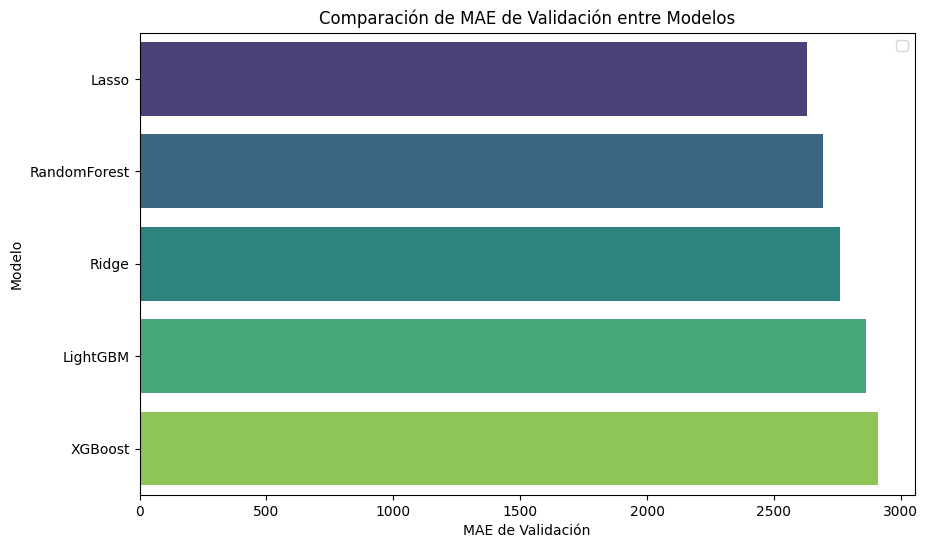

In [13]:
# Comparación de MAE de validación entre modelos (en horizontal)
# un color para cada modelo
# linea vertical con criterio de aprobación en mae = 4000
plt.figure(figsize=(10, 6))
sns.barplot(x='mae', y='model', data=results_df, palette='viridis', hue='model')
plt.xlabel('MAE de Validación')
plt.ylabel('Modelo')
plt.title('Comparación de MAE de Validación entre Modelos')
plt.legend()
plt.show()

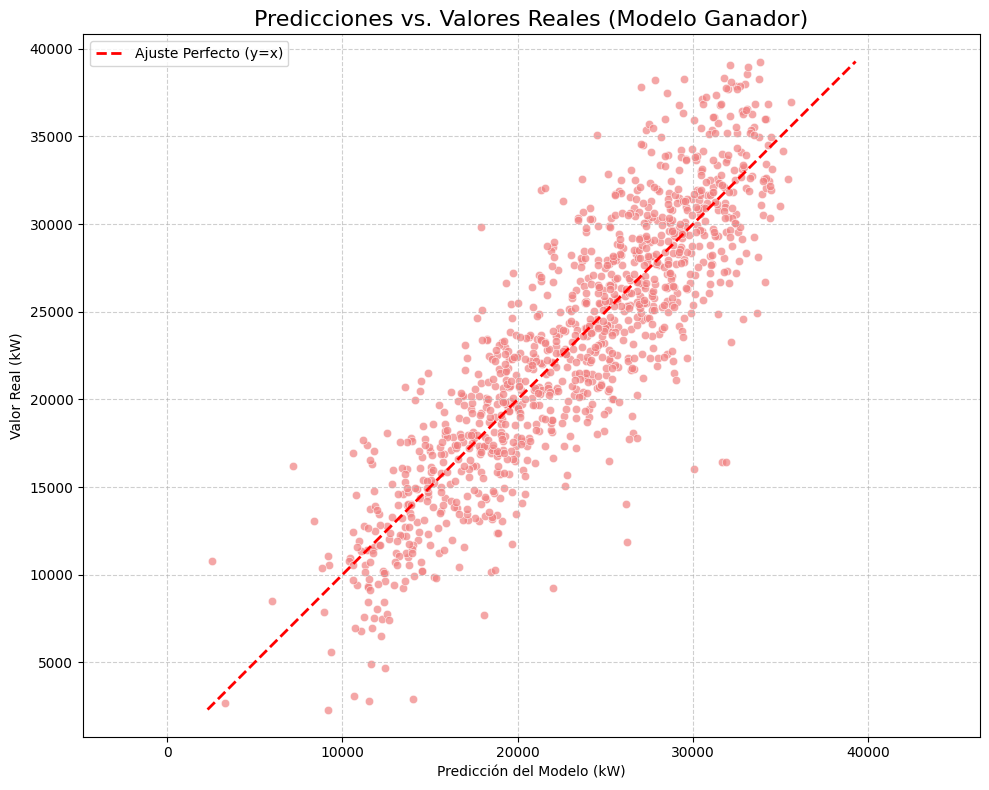

In [18]:

try:
    # Generar las predicciones del modelo ganador sobre todos los datos
    y_pred_full = final_model.predict(X_full)

    plt.figure(figsize=(10, 8))
    
    # Graficar los puntos en ROSA (color='lightcoral')
    sns.scatterplot(x=y_pred_full, y=y_full, alpha=0.7, color='lightcoral', edgecolor='w') 

    # Se calcula el rango de los datos para dibujar la línea diagonal de 45 grados.
    min_val = min(y_full.min(), y_pred_full.min())
    max_val = max(y_full.max(), y_pred_full.max())
    
    # Graficar la línea de ajuste perfecto en ROJO y discontinua (linestyle='--')
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', linewidth=2, label='Ajuste Perfecto (y=x)')

    plt.title('Predicciones vs. Valores Reales (Modelo Ganador)', fontsize=16)
    plt.xlabel('Predicción del Modelo (kW)')
    plt.ylabel('Valor Real (kW)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal') # Asegura que la escala de los ejes sea la misma
    plt.tight_layout()
    plt.show()

except NameError:
    print("ERROR: No se encontraron 'final_model', 'X_full' o 'y_full'.")
    print("Asegúrate de haber ejecutado las celdas anteriores, especialmente la celda 10 donde se definen y entrenan.")
except Exception as e:
    print(f"Ha ocurrido un error inesperado durante la predicción o el gráfico: {e}")

In [ ]:
import json
import os

# Nombre del archivo que tu código debe haber creado
file_name = 'model_registry.json'

print("Cerramos la Fase 3 guardando el modelo entrenado y registrándolo en un JSON. Aquí guardamos su versión, sus métricas y el hash de Git del código que lo creó. Total trazabilidad.")
print("="*80)
print(f"\nContenido del archivo de registro ('{file_name}'):\n")

# Comprobamos si el archivo existe antes de intentar leerlo
if os.path.exists(file_name):
    # Abrimos y cargamos el JSON para imprimirlo de forma bonita
    with open(file_name, 'r') as f:
        registry_data = json.load(f)
        # Usamos json.dumps con indent=4 para una presentación clara
        print(json.dumps(registry_data, indent=4))
else:
    print(f"ERROR: El archivo '{file_name}' no se encontró en la ruta actual.")
    print("Asegúrate de haber ejecutado la celda donde se guarda el modelo y se crea el JSON.")

Cerramos la Fase 3 guardando el modelo entrenado y registrándolo en un JSON. Aquí guardamos su versión, sus métricas y el hash de Git del código que lo creó. Total trazabilidad.

Contenido del archivo de registro ('model_registry.json'):

ERROR: El archivo 'model_registry.json' no se encontró en la ruta actual.
Asegúrate de haber ejecutado la celda donde se guarda el modelo y se crea el JSON.
